In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv("C:/Users/xhuli/Documents/GIT_REPOS/DM2Project/trainingDataAfterDataUnderstanding.csv")
data["Weekend"]=data["Weekend"].map(lambda x: 1 if x=="yes" else 0)

In [3]:
data.head()

,Temperature,Humidity,Light,CO2,Occupancy,Weekend,working_hours
0,23.18,27.2720,426.0,721.25,1,0,1
1,23.15,27.2675,429.5,714.00,1,0,1
2,23.15,27.2450,426.0,713.50,1,0,1
3,23.15,27.2000,426.0,708.25,1,0,1
4,23.10,27.2000,426.0,704.50,1,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
Temperature      8143 non-null float64
Humidity         8143 non-null float64
Light            8143 non-null float64
CO2              8143 non-null float64
Occupancy        8143 non-null int64
Weekend          8143 non-null int64
working_hours    8143 non-null int64
dtypes: float64(4), int64(3)
memory usage: 445.4 KB


# Partition features and target while scaling

In [5]:
data_x=data.drop(columns="Occupancy")

data_y=data["Occupancy"]

from sklearn.preprocessing import StandardScaler

data_x = pd.DataFrame((StandardScaler().fit_transform(data_x.select_dtypes(include=["int64", "float"]))), 
                      columns=(data_x.select_dtypes(include=["int64", "float"])).columns)

# Define selection algorithm and input data

In [10]:
def run_dim_reduction_algo(algo_instance, data_x, data_y=0):
    
    if str(algo_instance)[0:3] in ["RFE", "Sel"]:
        filtered_data=algo_instance.fit_transform(data_x,data_y)
        remaining_features=list(data_x.loc[:5, algo_instance.get_support()].columns)
    else:
        # we don't need the data_y if we are not using RFE or Univariate Feature Selection
        filtered_data=algo_instance.fit_transform(data_x)
        remaining_features=list(data_x.loc[:5, algo_instance.get_support()].columns)
        
    print("The remaining features are:")
    print(remaining_features)

# Variance threshold

In [11]:
from sklearn.feature_selection import VarianceThreshold
variance_x=VarianceThreshold(threshold=0.16)

In [12]:
run_dim_reduction_algo(variance_x, data_x)

The remaining features are:
['Temperature', 'Humidity', 'Light', 'CO2', 'working_hours']


# Univariate Feature Selection

In [13]:
from sklearn.feature_selection import SelectKBest
sel = SelectKBest(k=2)

In [14]:
run_dim_reduction_algo(sel, data_x, data_y)

The remaining features are:
['Light', 'CO2']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:114: UserWarning: Features [4] are constant.
  UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# Recursive feature elimination

In [15]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
rfe_algo=RFE(estimator=DecisionTreeClassifier(),n_features_to_select=2)

In [16]:
run_dim_reduction_algo(rfe_algo, data_x, data_y)

The remaining features are:
['Light', 'CO2']


# Principal Component Analysis

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [18]:
data_numeric=data_x.select_dtypes(include=["int", "float"])

filtered_data=pca.fit_transform(data_numeric)

principalDf = pd.DataFrame(data = filtered_data, columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, data_y], axis = 1)

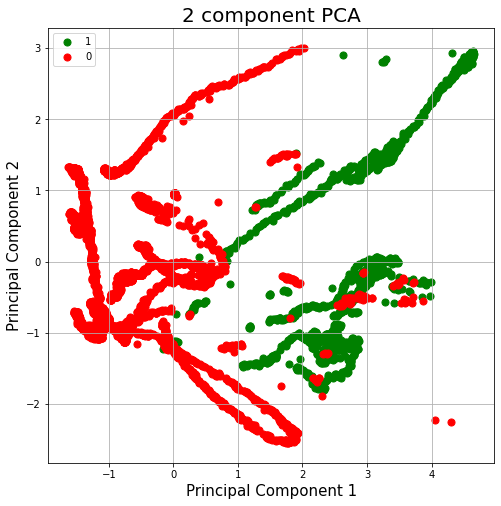

In [19]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = [1,0]
colors = ['g', 'r']

for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Occupancy'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

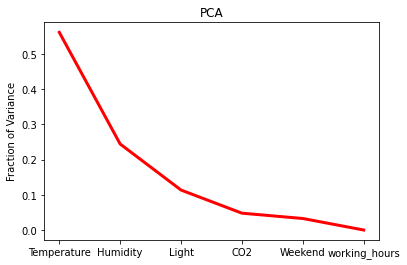

In [20]:
plt.plot(PCA(n_components=6).fit(data_numeric).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.xticks(range(6), data_x.columns)
plt.show()

# Classification with all features

In [22]:
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.3, random_state=100, stratify=data_y)

In [26]:
clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9901760130986492
F1-score [0.99378882 0.97651663]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1924
           1       0.99      0.96      0.98       519

    accuracy                           0.99      2443
   macro avg       0.99      0.98      0.99      2443
weighted avg       0.99      0.99      0.99      2443



# Classification with only 2 features

In [32]:
X_train_pca = pca.transform(X_train)

In [33]:
X_test_pca = pca.transform(X_test)

clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9873106835857552
F1-score [0.99195432 0.96999032]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1924
           1       0.97      0.97      0.97       519

    accuracy                           0.99      2443
   macro avg       0.98      0.98      0.98      2443
weighted avg       0.99      0.99      0.99      2443

